# Create initial multiple targets designs

This notebook generates the initial designs of double and triple targets for isoprenol producing P. putida strains. The targets are chosen randomly and proportionly to the ratios of isoprenol titer of single targets vs the control strain.


Tested using **ART 3.9.4** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `CRISPRi_targets.csv`

**File generated by running this notebook**
- `edd_experiment_description.xlsx`

containing the Line Names with chosen targets.

The files are stored in the user defined directory. 

## Setup

Importing needed libraries:

In [1]:
import os
import re    
import pandas as pd
import numpy as np
from math import comb
import random
import matplotlib.pyplot as plt


## User parameters

In [2]:
CYCLE = 1

user_params = {
    'targets_file': f'../data/CRISPRi_targets.csv',
    'output_file_path': f'../data/DBTL{CYCLE}', # Folder for output files,
    'control_value': 845.727575,  # from the EDD study, Hector's notebook
    'media': 'M9 (NREL), 2% glucose',
    'culture_volume': 5,
    'flask_type': 'Glass tubes',
    'strain': 'P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675',
    'shaking_speed': 200,
    'temperature': 30,
    'starting_od': 0.2,
    'fermentation_time': 48,
    'induction_time': 4, 
}

Here we specify how many instances (designs) we want to create and how many replicates (change as desired). 

In [3]:
user_params['n_instances_double'] = 15
user_params['n_instances_triple'] = 15
user_params['n_replicates'] = 3 

In [4]:
os.makedirs(user_params["output_file_path"], exist_ok=True)


## Helping functions for sampling, plotting and creating EDD experiment description file

Define a function that chooses a list of `n_instances` targets of size `size` out of the whole list of possible targets stored in the `df_targets` dataframe. The targets are chosen randomly with a probability proportional to the ratio of their improved production over the control.

In [5]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):

    targets_list = list(df_targets['Targets'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = sorted(random.sample(targets_list, counts=weights, k=size))
        if len(set(new_target)) == size:
            targets.add(tuple(new_target))
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [6]:
 def plot_double_targets(targets_double, df_targets):
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Targets']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Targets']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Targets'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Targets'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Targets'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [7]:
 def plot_triple_targets(targets_triple, df_targets):
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Targets']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Targets']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Targets']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Targets'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

In [8]:
def create_edd_exp_descr_file(line_names, user_params):
    df = pd.DataFrame()
    df['Line Name'] = line_names
    df['Line Description'] = None
    df['Media'] = user_params['media']
    df['Fermentation Strain'] = user_params['strain']
    df['Culture Volume'] = user_params['culture_volume']
    df['Flask Type'] = user_params['flask_type']
    df['Growth Temperature'] = user_params['temperature']
    df['Shaking speed'] = user_params['shaking_speed']
    df['Fermentation Time'] = user_params['fermentation_time']
    df['Starting OD'] = user_params['starting_od']
    df['Induction Time'] = user_params['induction_time']
    df['Replicate Count'] = user_params['n_replicates']
    
    exp_descr_file = f'{user_params["output_file_path"]}/edd_experiment_description.xlsx'
    df.to_excel(exp_descr_file, index=False)

    return df

## Load the data

Read the targets list and remove the prefix

In [9]:
df_targets = pd.read_csv(user_params['targets_file'])
find_gene = lambda x: re.sub('PP_', '', x)
df_targets['Targets'] =  df_targets['Targets'].apply(find_gene)

Using ratios of isoprenol production value of each strain and the control one, find weights that will determine the probability of a target being chosen:

In [10]:
for ind in df_targets.index:
    
    value = np.mean(df_targets.loc[ind][['Min production', 'Max production']])
    ratio = value/user_params['control_value']
    
    df_targets.loc[ind, 'Weight']= round(ratio*10)
    
df_targets = df_targets.astype({'Weight': 'int'})


In [11]:
df_targets = df_targets[['Targets', 'Ratio', 'Weight']]

In [12]:
df_targets.tail()

,Targets,Ratio,Weight
20,4635,0.745238,11
21,4679,1.661620,11
22,4679,1.661620,11
23,5186,1.163789,12
24,5419,1.518582,11


One of the targets is repeated!

In [13]:
df_targets.drop(index=22, inplace=True)
df_targets.reset_index(drop=True, inplace=True)

In [14]:
df_targets

,Targets,Ratio,Weight
0,0104,1.157629,11
1,0105,1.677690,11
2,0225,0.764675,11
3,0277,1.713088,11
4,0654,3.971140,12
5,0813,3.023722,12
6,0814,0.816739,11
7,0944,2.065723,11
8,0999,0.773752,11
9,1023,1.078688,11


In [15]:
n_targets = len(df_targets['Targets'])

How many designs with double-targets are possible?

In [16]:
n_double_total = comb(n_targets, 2)
print(f"Out of {n_double_total} double-target designs we will test {user_params['n_instances_double']} ({user_params['n_instances_double']/n_double_total:.2}%)")


Out of 276 double-target designs we will test 15 (0.054%)


How many designs with triple targets are possible?

In [17]:
n_triple_total = comb(n_targets, 3)
print(f"Out of {n_triple_total} triple-target designs we will test {user_params['n_instances_triple']} ({user_params['n_instances_triple']/n_triple_total:.2}%)")


Out of 2024 triple-target designs we will test 15 (0.0074%)


## Choose a set of double targets

In [38]:
targets_double = choose_targets(
    df_targets, 
    size=2, 
    n_instances=user_params['n_instances_double'],
    weighting=True, 
)

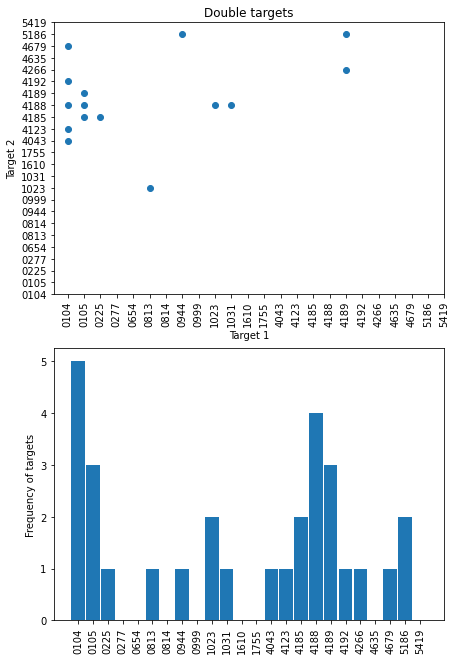

In [39]:
plot_double_targets(targets_double, df_targets)

In [60]:
targets_triple = choose_targets(
    df_targets, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
    weighting=True,
)


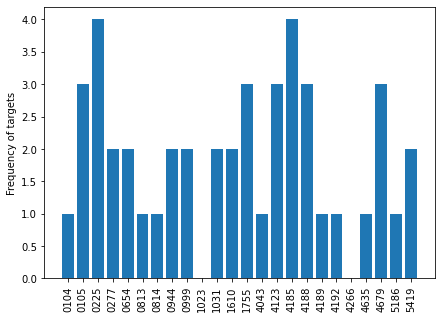

In [61]:
plot_triple_targets(targets_triple, df_targets)

## Saving the generated designs

In [62]:
line_names_double = []
for i in range(len(targets_double)):
    line_names_double.append(f'PP_{targets_double[i][0]}_{targets_double[i][1]}')

line_names_triple = []
for i in range(len(targets_triple)):
    line_names_triple.append(f'PP_{targets_triple[i][0]}_{targets_triple[i][1]}_{targets_triple[i][2]}')


## Create EDD Experiment Description File

Create Line Names:

In [63]:
line_names = line_names_double
line_names.extend(line_names_triple)

In [64]:
df_edd = create_edd_exp_descr_file(line_names, user_params)
df_edd.head()

,Line Name,Line Description,Media,Fermentation Strain,Culture Volume,Flask Type,Growth Temperature,Shaking speed,Fermentation Time,Starting OD,Induction Time,Replicate Count
0,PP_4189_4266,None,"M9 (NREL), 2% glucose",P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675,5,Glass tubes,30,200,48,0.2,4,3
1,PP_0104_4679,None,"M9 (NREL), 2% glucose",P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675,5,Glass tubes,30,200,48,0.2,4,3
2,PP_0104_4123,None,"M9 (NREL), 2% glucose",P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675,5,Glass tubes,30,200,48,0.2,4,3
3,PP_0105_4189,None,"M9 (NREL), 2% glucose",P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675,5,Glass tubes,30,200,48,0.2,4,3
4,PP_0104_4043,None,"M9 (NREL), 2% glucose",P. putida KT2440 ∆phaABC∆mvaB∆hbdH∆ldhA∆PP2675,5,Glass tubes,30,200,48,0.2,4,3


In [65]:
len(df_edd)

30